In [1]:
# extract the features from the echonest file

In [31]:
import pandas as pd
import warnings

df = pd.read_csv('echonest-simple.csv')

# we can tweak these after comparing to other models
# in order: acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence
thresholds = []

for column in df.columns[1:]:

    percent_val = df[column].quantile(0.8)
    thresholds.append(percent_val)

print(thresholds)


binary_df = df.copy()

def convert_to_binary(value, percentile):
    if value > percentile:
        return 1
    else:
        return 0


for column, threshold in zip(df.columns[1:], thresholds):

    binary_df[column] = binary_df[column].apply(lambda x: convert_to_binary(x, threshold))
    

new_column_names = ['track_id'] + ['acoustic', 'danceable', 'energetic', 'instrumental', 'lively', 'speechy', 'fast', 'happy']
binary_df.columns = new_column_names

binary_df = binary_df.drop('fast', axis=1)

binary_df.to_csv("trackid_labels.csv", index=False)
print("file written")

[0.9531798796000001, 0.6642637476000001, 0.8203342636000001, 0.9287286102, 0.264313338, 0.105355736, 152.5558, 0.7160069330000002]
file written


In [28]:
import os

def add_to_fname_list(folder_path, fnames, file_names, genre):
    
    for file_name in file_names:
        file_path = folder_path + '/' + file_name
        fnames.append([file_path, genre])

hiphop_folder_path = './fma_smaller/HipHop'
instrumental_folder_path = './fma_smaller/Instrumental'
folk_folder_path = './fma_smaller/Folk'
rock_folder_path = './fma_smaller/Rock'

genres = ["HipHop", "Instrumental", "Folk", "Rock"]
# genres list

fnames = []
file_names = os.listdir(hiphop_folder_path)
add_to_fname_list(hiphop_folder_path, fnames, file_names, 0)

file_names = os.listdir(instrumental_folder_path)
add_to_fname_list(instrumental_folder_path, fnames, file_names, 1)

file_names = os.listdir(folk_folder_path)
add_to_fname_list(folk_folder_path, fnames, file_names, 2)

file_names = os.listdir(rock_folder_path)
add_to_fname_list(rock_folder_path, fnames, file_names, 3)

In [55]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

tag_df = pd.read_csv('trackid_labels.csv')

audio_features = []
target = []

skipped = 0

for (i,fname) in enumerate(fnames): 
    genre = fname[1]
    audio, srate = librosa.load(fname[0])
    mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate)
    mean_mfcc = np.mean(mfcc_matrix,axis=1)
    std_mfcc = np.std(mfcc_matrix, axis=1)
    audio_fvec = np.hstack([mean_mfcc, std_mfcc])

    fname_list = fname[0].split('/')
    track_id = int(fname_list[3][:6])

    match = tag_df[tag_df['track_id'] == track_id]
    
    if match.empty:
        skipped += 1
        print("Skipped %s" % (fname))
    else:
        audio_features.append(audio_fvec)
        values_list = match.values.tolist()[0][1:]
        target.append(np.hstack([genre] + values_list))
        # print(np.hstack([genre] + values_list))
        print("Processed %s" % (fname))
    

Processed ['./fma_smaller/HipHop/000002.mp3', 0]
Processed ['./fma_smaller/HipHop/000005.mp3', 0]
Skipped ['./fma_smaller/HipHop/000676.mp3', 0]
Processed ['./fma_smaller/HipHop/000694.mp3', 0]
Processed ['./fma_smaller/HipHop/000695.mp3', 0]
Processed ['./fma_smaller/HipHop/004682.mp3', 0]
Processed ['./fma_smaller/HipHop/004684.mp3', 0]
Processed ['./fma_smaller/HipHop/004685.mp3', 0]
Processed ['./fma_smaller/HipHop/004688.mp3', 0]
Processed ['./fma_smaller/HipHop/005264.mp3', 0]
Processed ['./fma_smaller/HipHop/005268.mp3', 0]
Skipped ['./fma_smaller/HipHop/006439.mp3', 0]
Skipped ['./fma_smaller/HipHop/006440.mp3', 0]
Skipped ['./fma_smaller/HipHop/006442.mp3', 0]
Skipped ['./fma_smaller/HipHop/006443.mp3', 0]
Skipped ['./fma_smaller/HipHop/006448.mp3', 0]
Processed ['./fma_smaller/HipHop/006603.mp3', 0]
Processed ['./fma_smaller/HipHop/006605.mp3', 0]
Processed ['./fma_smaller/HipHop/006606.mp3', 0]
Processed ['./fma_smaller/HipHop/006607.mp3', 0]
Processed ['./fma_smaller/HipHop

In [56]:
np_audio_features = np.array(audio_features)
np_target = np.array(target)

In [81]:
from sklearn import svm, metrics
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np_audio_features, np_target, test_size=0.3, random_state=42)

for_clf = RandomForestClassifier()
for_clf.fit(X_train, y_train)

# print("Confusion matrix:\n%s" % metrics.confusion_matrix(np_target, predicted))
# print("Classification report for classifier %s:\n%s\n" % (for_clf, metrics.accuracy_score(target, predicted)))

RandomForestClassifier()

In [83]:
predicted = for_clf.predict(X_test)

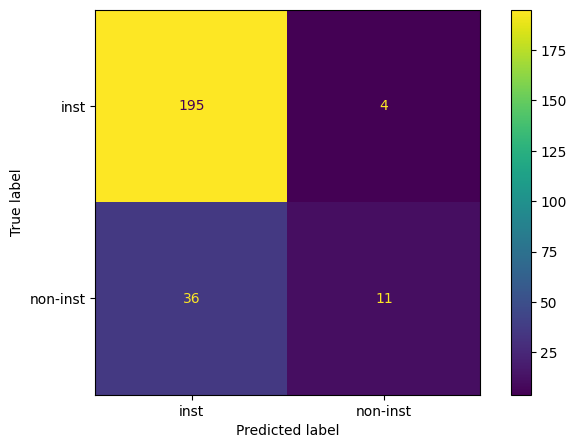

Classification report for classifier RandomForestClassifier():
0.8373983739837398



In [84]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# print("Confusion matrix:\n%s" % metrics.confusion_matrix(np_target[:, 3], predicted[:, 3]))
fig, ax = plt.subplots(figsize=(8,5))
index = 4

cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test[:, index], predicted[:, index]),
    display_labels = ["inst", "non-inst"],
)

cmp.plot(ax=ax)
plt.show()
    
print("Classification report for classifier %s:\n%s\n" % (for_clf, metrics.accuracy_score(y_test[:, index], predicted[:, index])))

